In [1]:
!nvidia-smi

Thu Jan 11 23:12:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  | 00000000:4F:00.0 Off |                  Off |
| 30%   33C    P8              23W / 300W |  37747MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# # download data
# !wget -O covid_train.csv https://www.dropbox.com/s/lmy1riadzoy0ahw/covid.train.csv?dl=0
# !wget -O covid_test.csv https://www.dropbox.com/s/zalbw42lu4nmhr2/covid.test.csv?dl=0

In [3]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

In [4]:
# Configurations
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 42,      # Your seed number, you can pick your lucky number. :)
    'select_all': False,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 3000,     # Number of epochs.            
    'batch_size': 64, 
    'learning_rate': 1e-5,              
    'early_stop': 120,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt',  # Your model will be saved here.
    'loss_save_path': './output/' # Your loss will be saved here.
}

In [5]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [6]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [7]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = list(range(35, raw_x_train.shape[1])) # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid


## Dataloader

In [8]:
# Set seed for reproducibility
same_seed(config['seed'])

# train_data size: 3009 x 89 (35 states + 18 features x 3 days) 
# test_data size: 997 x 88 (without last day's positive rate)
train_data, test_data = pd.read_csv('./covid_train.csv').values, pd.read_csv('./covid_test.csv').values
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} 
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data , config['select_all'])

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)


train_data size: (2408, 89) 
valid_data size: (601, 89) 
test_data size: (997, 88)
number of features: 53


In [9]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x 

In [10]:
def trainer(train_loader, valid_loader, model, config, device):
    train_loss_l = []
    val_loss_l = []

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    # optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.7) 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08 , weight_decay=1) 
    # writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        # train_pbar = tqdm(train_loader, position=0, leave=True)
        
        for x, y in train_loader:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # # Display current epoch number and loss on tqdm progress bar.
            # train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            # train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        train_loss_l.append(mean_train_loss)
        # writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        val_loss_l.append(mean_valid_loss)
        # print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        # writer.add_scalar('Loss/valid', mean_valid_loss, step)
        
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            if epoch/100 ==0:
                print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            print('Saving model with loss {:.3f}...'.format(best_loss))
            return train_loss_l, val_loss_l
    return train_loss_l, val_loss_l
    


## Training

In [11]:
model = My_Model(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
train_loss , val_loss = trainer(train_loader, valid_loader, model, config, device)

Saving model with loss 132.009...

Model is not improving, so we halt the training session.
Saving model with loss 1.014...


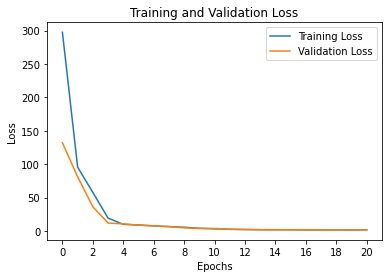

In [12]:
### plot 
from matplotlib.pylab import plt
from numpy import arange



plt.plot(train_loss[:21], label='Training Loss')
plt.plot(val_loss[:21], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(arange(0, 21, 2))
plt.legend(loc='best')
plt.show()
 



## Prediction

In [13]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device) 
save_pred(preds, 'pred.csv')         

100%|██████████| 16/16 [00:00<00:00, 1481.50it/s]


## Show Case
* YOU DONNOT NEED TO RUN THIS UNLESS UR TRYING TO KEEP TRACK OF VARIOUS TRAINING SETTING

In [14]:
"""SAVING FILE"""
import pickle

if not os.path.isdir('./output'):
    os.mkdir('./output') # Create directory of saving training and validating loss.

## TODO: Change the file name respect to you experiments
exp = '_Optimizer' 

# save the files
train_file_path = config['loss_save_path']+exp+'_train.pkl'
val_file_path = config['loss_save_path']+exp+'_val.pkl'
# Save the list to a file using pickle
with open(train_file_path, 'wb') as file:
    pickle.dump(train_loss, file)
with open(val_file_path, 'wb') as file:
    pickle.dump(val_loss, file)

In [15]:
"""EXTRACTING　FILE"""
import os
import pickle

# Specify the folder path
folder_path = config['loss_save_path']

# Lists to store the loaded data
train_loss_list = []
val_loss_list = []

# List all files in the folder
all_files = os.listdir(folder_path)

# Filter files ending with '_train.pkl' or '_val.pkl'
train_files = [file for file in all_files if file.endswith('_train.pkl')]
val_files = [file for file in all_files if file.endswith('_val.pkl')]

# Load data from '_train.pkl' files
for train_file in train_files:
    file_path = os.path.join(folder_path, train_file)
    with open(file_path, 'rb') as file:
        train_data = pickle.load(file)
        train_loss_list.append(train_data)

# Load data from '_val.pkl' files
for val_file in val_files:
    file_path = os.path.join(folder_path, val_file)
    with open(file_path, 'rb') as file:
        val_data = pickle.load(file)
        val_loss_list.append(val_data)

# Print or use the loaded data as needed
print("Train Data List:", train_loss_list)
print("Validation Data List:", val_loss_list)


Train Data List: [[297.5161050495349, 95.54015390496505, 57.75089660443758, 19.284453642995732, 10.000176592877036, 9.010961281625848, 7.736847538697092, 6.554728633479068, 5.590641009180169, 4.065831378886574, 3.2780146128252934, 2.637257240320507, 2.175442792867359, 1.968219076332293, 1.8213011465574567, 1.8776458407703198, 1.6948697033681368, 1.6611728574100293, 1.6841943201265837, 1.6334581469234668, 1.7528429094113802, 1.6190802611802753, 1.566670232697537, 1.6184329861088802, 1.5252245335202468, 1.5348422244975441, 1.5453669617050572, 1.6220519950515346, 1.6003849271096682, 1.4688862122987445, 1.5797928540330184, 1.508784974876203, 1.474557671107744, 1.530038203063764, 1.4760104543284367, 1.46904919022008, 1.4152059288401353, 1.403342621891122, 1.486754994643362, 1.4821057429439144, 1.392921877534766, 1.3688176415468518, 1.385238804315266, 1.4815788425897296, 1.4262333967183765, 1.4256951322681026, 1.365284329966495, 1.34013600412168, 1.4734944936476255, 1.3654877166999013, 1.337

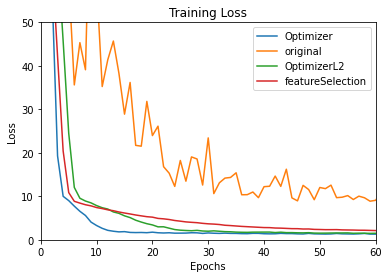

In [16]:
# Plot train loss 
for i, sublist in enumerate(train_loss_list):
    plt.plot(sublist, label=train_files[i].replace('_train.pkl','').replace('_',''))

# Add labels and legend
# narrow into a smaller range
plt.ylim(0,50)
plt.xlim(0,60)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Show the plot
plt.show()


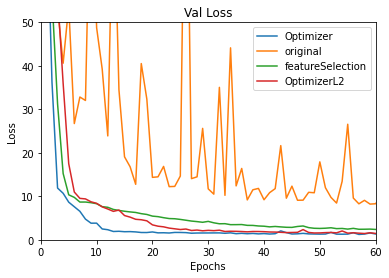

In [17]:
# Plot val loss 
for i, sublist in enumerate(val_loss_list):
    plt.plot(sublist, label=val_files[i].replace('_val.pkl','').replace('_',''))

# Add labels and legend
plt.ylim(0,50)
plt.xlim(0,60)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Val Loss')
plt.legend()

# Show the plot
plt.show()